# CW09 - GUI paper exploration 9 - smooth U-Net
Optional: Show you U-Nets can learn image posteriors. It might be more interesting to use examples from Elias.

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType

## Model

In [3]:
N = 40  # Number of data bins
SIGMA = 0.5  # Measurement uncertainty
NRES = 6

In [4]:
# Noise-free model
NPAR = 4

# Model and reference parameters
def spec(a, b, c, d, LW = 0.5):
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    x = spec(v[0], v[1], v[2], v[3])
    return dict(x=x)

# Noise model
def noise(sim, v, sigma = SIGMA):
    noise = np.random.randn(N)*sigma
    return dict(x = sim['x'] + noise)

# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 1.).ppf(u[0])
    b = scipy.stats.uniform(-1., 1.).ppf(u[1])
    c = scipy.stats.uniform(0., 10.).ppf(u[2])
    d = scipy.stats.uniform(0, 10.).ppf(u[3])
    return np.array([a, b, c, d])

### Zoom in

In [5]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,)))

In [6]:
prior = swyft.Prior(transform, NPAR)

In [42]:
NTRAIN = 10000

In [43]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 10020 new samples to simulator store.


In [44]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

In [239]:
class MyNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv1d(1, 3, 21)
        self.c2 = nn.Conv1d(3, 512, 1, padding = 0)
        self.c3a = nn.Conv1d(512, 512, 1, padding = 0)
        self.c3b = nn.Conv1d(512, 8, 1, padding = 0)
        #self.c4 = nn.ConvTranspose2d(4, 2, [21, 21], stride = [10, 10])
        self.c4 = nn.ConvTranspose1d(8, 4, 5, stride=2)
        self.c5 = nn.ConvTranspose1d(4, 2, 5, stride=2)
        self.c6 = nn.ConvTranspose1d(2, 2, 5, stride=1)
        self.ac = nn.ReLU()
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.c1(x)
        x = self.c2(x)
        x = self.ac(x)
        x = self.c3a(x)
        x = self.ac(x)
        x = self.c3b(x)
        x = self.c4(x)
        #x = self.ac(x)
        x = self.c5(x)
        #x = self.ac(x)
        x = self.c6(x)
        x = x.reshape(-1, 1, 2, x.size()[-1])
        x = torch.swapaxes(x, 2, 3)
        return x

mn3 = MyNet4()
mn3(torch.rand(3, 40)).shape

torch.Size([3, 1, 93, 2])

In [240]:
NRES1 = 1
NRES2 = 93

class MyTail(Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net3 = MyNet4()

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        t1 = torch.tensor(params[:,2]*NRES1, dtype = torch.long)
        t2 = torch.tensor(params[:,3]*NRES2, dtype = torch.long)
        t1 = nn.functional.one_hot(t1, num_classes = NRES1) # nbatch, nmarg1
        t2 = nn.functional.one_hot(t2, num_classes = NRES2) # nbatch, nmarg2
        t = torch.matmul(t1.unsqueeze(2).float(), t2.unsqueeze(1).float()).long() # nbatch, nmarg1, nmarg2
        x = self.net3(f) # nbatch, nmarg1, nmarg2, 2
        nbatch = x.size(0)
        x = x.reshape(-1, 2)
        t = t.reshape(-1)
        x = x[torch.arange(len(t)), t].reshape(nbatch, NRES1, NRES2) # nbatch, nmarg1, nmarge2
        return x.reshape(nbatch, -1)

In [241]:
post = swyft.Posteriors(dataset)
partition = range(1)
post.add(partition, device='cuda', head = swyft.DefaultHead, tail = MyTail)

In [245]:
post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 128, optimizer_args = dict(lr = 0.01))

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Training: lr=3.9e-05, Epoch=22, VL=128.3, TL=128.3


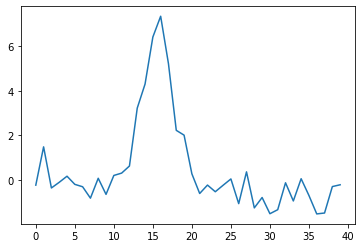

In [243]:
v0 = np.array([0.0, -0.1, 9.5, 4.0])
obs0 = noise(model(v0), v0)
plt.plot(obs0['x'])

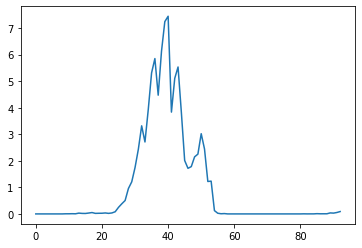

In [244]:
tail = post._ratios[((0,),)].tail.net3
head = post._ratios[((0,),)].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))
t1 = tail(f)[0,:,:,1].cpu().detach().numpy()
t2 = tail(f)[0,:,:,0].cpu().detach().numpy()
plt.plot(np.exp(t1[0]))
#plt.imshow(np.exp(1*t1), origin = 'lower')
#plt.colorbar()